In [51]:
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.svm import SVC
from tqdm import tqdm
import pickle


In [52]:
DATA_DIR = os.path.join("data")
MODEL_DIR = os.path.join("model")
CLASSIFIERS_NAMES = ['SVM', 'GB', 'GNB', 'LR', 'RF']
selected_data = "selected_dataset.tsv"
dataset_matrix = os.path.join(DATA_DIR, selected_data)
selected_data = pd.read_csv(dataset_matrix, delimiter="\t", index_col=0, low_memory=False)
x = selected_data.values
genes = selected_data.index
x.shape,genes.shape
# positive_genes = [line.rstrip('\n') for line in open(os.path.join(DATA_DIR, "test_positive_genes.txt"))]
# negative_genes = [line.rstrip('\n') for line in open(os.path.join(DATA_DIR, "test_negative_genes.txt"))]
# positive_data = selected_data.loc[positive_genes].values
# negative_data = selected_data.loc[negative_genes].values
# 
# y0 = np.zeros([len(negative_data), ])
# y1 = np.ones([len(positive_data), ])
# # 定义y
# y = np.concatenate([y0, y1], axis=0)
# # 定义x
# x = np.concatenate([np.array(negative_data), positive_data])
# x = torch.tensor(x, dtype=torch.float32)
# 
# gene_nums = len(x)
# genes = np.concatenate([negative_genes,positive_genes] ,axis=0)
# genes

((26936, 1517), (26936,))

In [53]:
pd_out = pd.DataFrame()
pd_out.insert(column="genes", value=genes, loc=0)
for classifier in tqdm(CLASSIFIERS_NAMES):
    mdls = os.listdir(os.path.join(MODEL_DIR, classifier))
    average_pred = pd.DataFrame()
    for i, mdl in tqdm(enumerate(mdls), total=len(mdls)):
        model = pickle.load(open(os.path.join(MODEL_DIR, classifier, mdl), 'rb'))
        pred = model.predict_proba(x)[:, -1]
        average_pred.insert(value=pred, column=f'round_{i}', loc=len(average_pred.columns))
    mean = average_pred.mean(axis=1)
    pd_out.insert(column=f'{classifier}_GAN_score', value=mean, loc=len(pd_out.columns))
pd_out

 57%|█████▋    | 100/176 [02:32<02:04,  1.63s/it]C:\Users\tuoge\AppData\Local\Temp\ipykernel_4580\875692208.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

 57%|█████▋    | 101/176 [02:33<02:04,  1.66s/it]C:\Users\tuoge\AppData\Local\Temp\ipykernel_4580\875692208.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

 58%|█████▊    | 102/176 [02:35<02:04,  1.68s/it]C:\Users\tuoge\AppData\Local\Temp\ipykernel_4580\875692208.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

,genes,SVM_GAN_score,GB_GAN_score,GNB_GAN_score,LR_GAN_score,RF_GAN_score
0,MACROD2,0.512037,0.267637,3.292097e-33,0.602046,0.383497
1,NCKAP5L,0.054833,0.087059,1.143964e-136,0.015866,0.155230
2,HES3,0.106838,0.125419,9.777385e-195,0.048665,0.219526
3,OR52R1,0.045121,0.056046,7.915134e-215,0.018189,0.043113
4,IZUMO2,0.040641,0.061080,2.154307e-194,0.022296,0.029541
...,...,...,...,...,...,...
26931,DEFB104B,0.031011,0.052296,5.549726e-217,0.013375,0.005952
26932,COL11A2P1,0.027250,0.052075,1.604792e-218,0.011246,0.003542
26933,KRTAP10-4,0.027250,0.052075,1.604792e-218,0.011246,0.003542
26934,KRTAP20-4,0.027250,0.052075,1.604792e-218,0.011246,0.003542


In [73]:
#model ensemble
top1_prob_genes  = pd.DataFrame()
sorted_prob_genes = pd.DataFrame()
for classifier in CLASSIFIERS_NAMES:
    score = pd_out[f'{classifier}_GAN_score']
    sorted_indices = np.argsort(score)[::-1]
    sorted_score = score[sorted_indices]
    sorted_genes = genes[sorted_indices]
    limit = int(len(sorted_genes) * 0.01)
    classifier_top1_genes = sorted_genes[:limit]
    classifier_top1_rob = sorted_score[:limit]
    sorted_prob_genes[f"{classifier}_GAN_predict"] = sorted_genes
    sorted_prob_genes[f"{classifier}_GAN_prob"] = sorted_score.values
    top1_prob_genes[f"{classifier}_GAN_predict"] = classifier_top1_genes
    top1_prob_genes[f"{classifier}_GAN_prob"] = classifier_top1_rob.values
    # print(top_1_percent_gene)
top1_prob_genes.to_csv(os.path.join("result","top1_prob_gens.csv"),index=False,sep='\t')
sorted_prob_genes.to_csv(os.path.join("result","sorted_prob_genes.csv"),index=False,sep='\t')
# pd_out.to_csv(os.path.join("GAN_SCORE.CSV"),index=False,sep='\t')

In [92]:
#合并reports
import pandas as pd
import os
CLASSIFIERS_NAMES = ['SVM', 'GB', 'GNB', 'LR', 'RF']
all_report = pd.DataFrame()
for classifier in CLASSIFIERS_NAMES:
    report = pd.read_csv(os.path.join("result","GO_TERMS_REPORTS",f'{classifier}_GO_REPORT.txt'),delimiter='\t')
    report["Term"] = [term.split("~")[-1] for term in report["Term"]]
    report["Classifier"] = classifier
    report.sort_values("Fold Enrichment",ascending=False, inplace=True)
    report_head = report.head(10)
    all_report = pd.concat([all_report,report_head],ignore_index=True,axis=0)
all_report.sort_values('Term',inplace=True)
all_report.sort_values('Classifier',inplace=True)
all_report
# len(all_report)

,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR,Classifier
11,GOTERM_MF_DIRECT,N(6)-L-threonylcarbamoyladenine synthase,2,4.081633,5.052756e-03,"OSGEPL1, OSGEP",49,2,18976,387.265306,4.004777e-01,8.589686e-02,7.579135e-02,GB
17,GOTERM_BP_DIRECT,tRNA threonylcarbamoyladenosine modification,2,4.081633,1.201786e-02,"OSGEPL1, OSGEP",48,5,19462,162.183333,8.719600e-01,1.450728e-01,1.321965e-01,GB
13,GOTERM_CC_DIRECT,tRNA (m1A) methyltransferase complex,2,4.081633,6.954145e-03,"TRMT61A, TRMT61B",49,3,20660,281.088435,4.737697e-01,7.108682e-02,5.949657e-02,GB
14,GOTERM_MF_DIRECT,tRNA (adenine-N1-)-methyltransferase activity,2,4.081633,7.569752e-03,"TRMT61A, TRMT61B",49,3,18976,258.176871,5.358063e-01,1.103021e-01,9.732538e-02,GB
19,GOTERM_MF_DIRECT,RNA methyltransferase activity,4,8.163265,3.288648e-06,"TGS1, BCDIN3D, TRMT2B, FTSJ1",49,12,18976,129.088435,3.320988e-04,1.677210e-04,1.479891e-04,GB
18,GOTERM_BP_DIRECT,rRNA methylation,6,12.244898,1.945411e-10,"TRMT112, DIMT1, TFB2M, TRMT2B, TFB1M, TRMT61B",48,15,19462,162.183333,3.307200e-08,1.095915e-08,9.986445e-09,GB
12,GOTERM_MF_DIRECT,"rRNA (adenine-N6,N6-)-dimethyltransferase acti...",3,6.122449,3.747132e-05,"DIMT1, TFB2M, TFB1M",49,4,18976,290.448980,3.777522e-03,1.274025e-03,1.124140e-03,GB
16,GOTERM_MF_DIRECT,mitochondrial RNA polymerase binding promoter ...,2,4.081633,1.008051e-02,"TFB2M, TFB1M",49,4,18976,193.632653,6.405924e-01,1.285265e-01,1.134058e-01,GB
15,GOTERM_BP_DIRECT,transcription initiation from mitochondrial pr...,2,4.081633,9.625653e-03,"TFB2M, TFB1M",48,4,19462,202.729167,8.068499e-01,1.251335e-01,1.140270e-01,GB
10,GOTERM_BP_DIRECT,positive regulation of pre-miRNA processing,2,4.081633,4.824217e-03,"TRUB1, DGCR8",48,2,19462,405.458333,5.604929e-01,6.794105e-02,6.191078e-02,GB


In [93]:
#调整p.adjust
from statsmodels.stats.multitest import multipletests
PAdjust = multipletests(all_report["PValue"],method='fdr_bh')[1]
all_report["PAdjust"] = PAdjust

C:\CondaEnvs\tmp0\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 12 x 6.5 in image.
C:\CondaEnvs\tmp0\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: go terms plot.svg


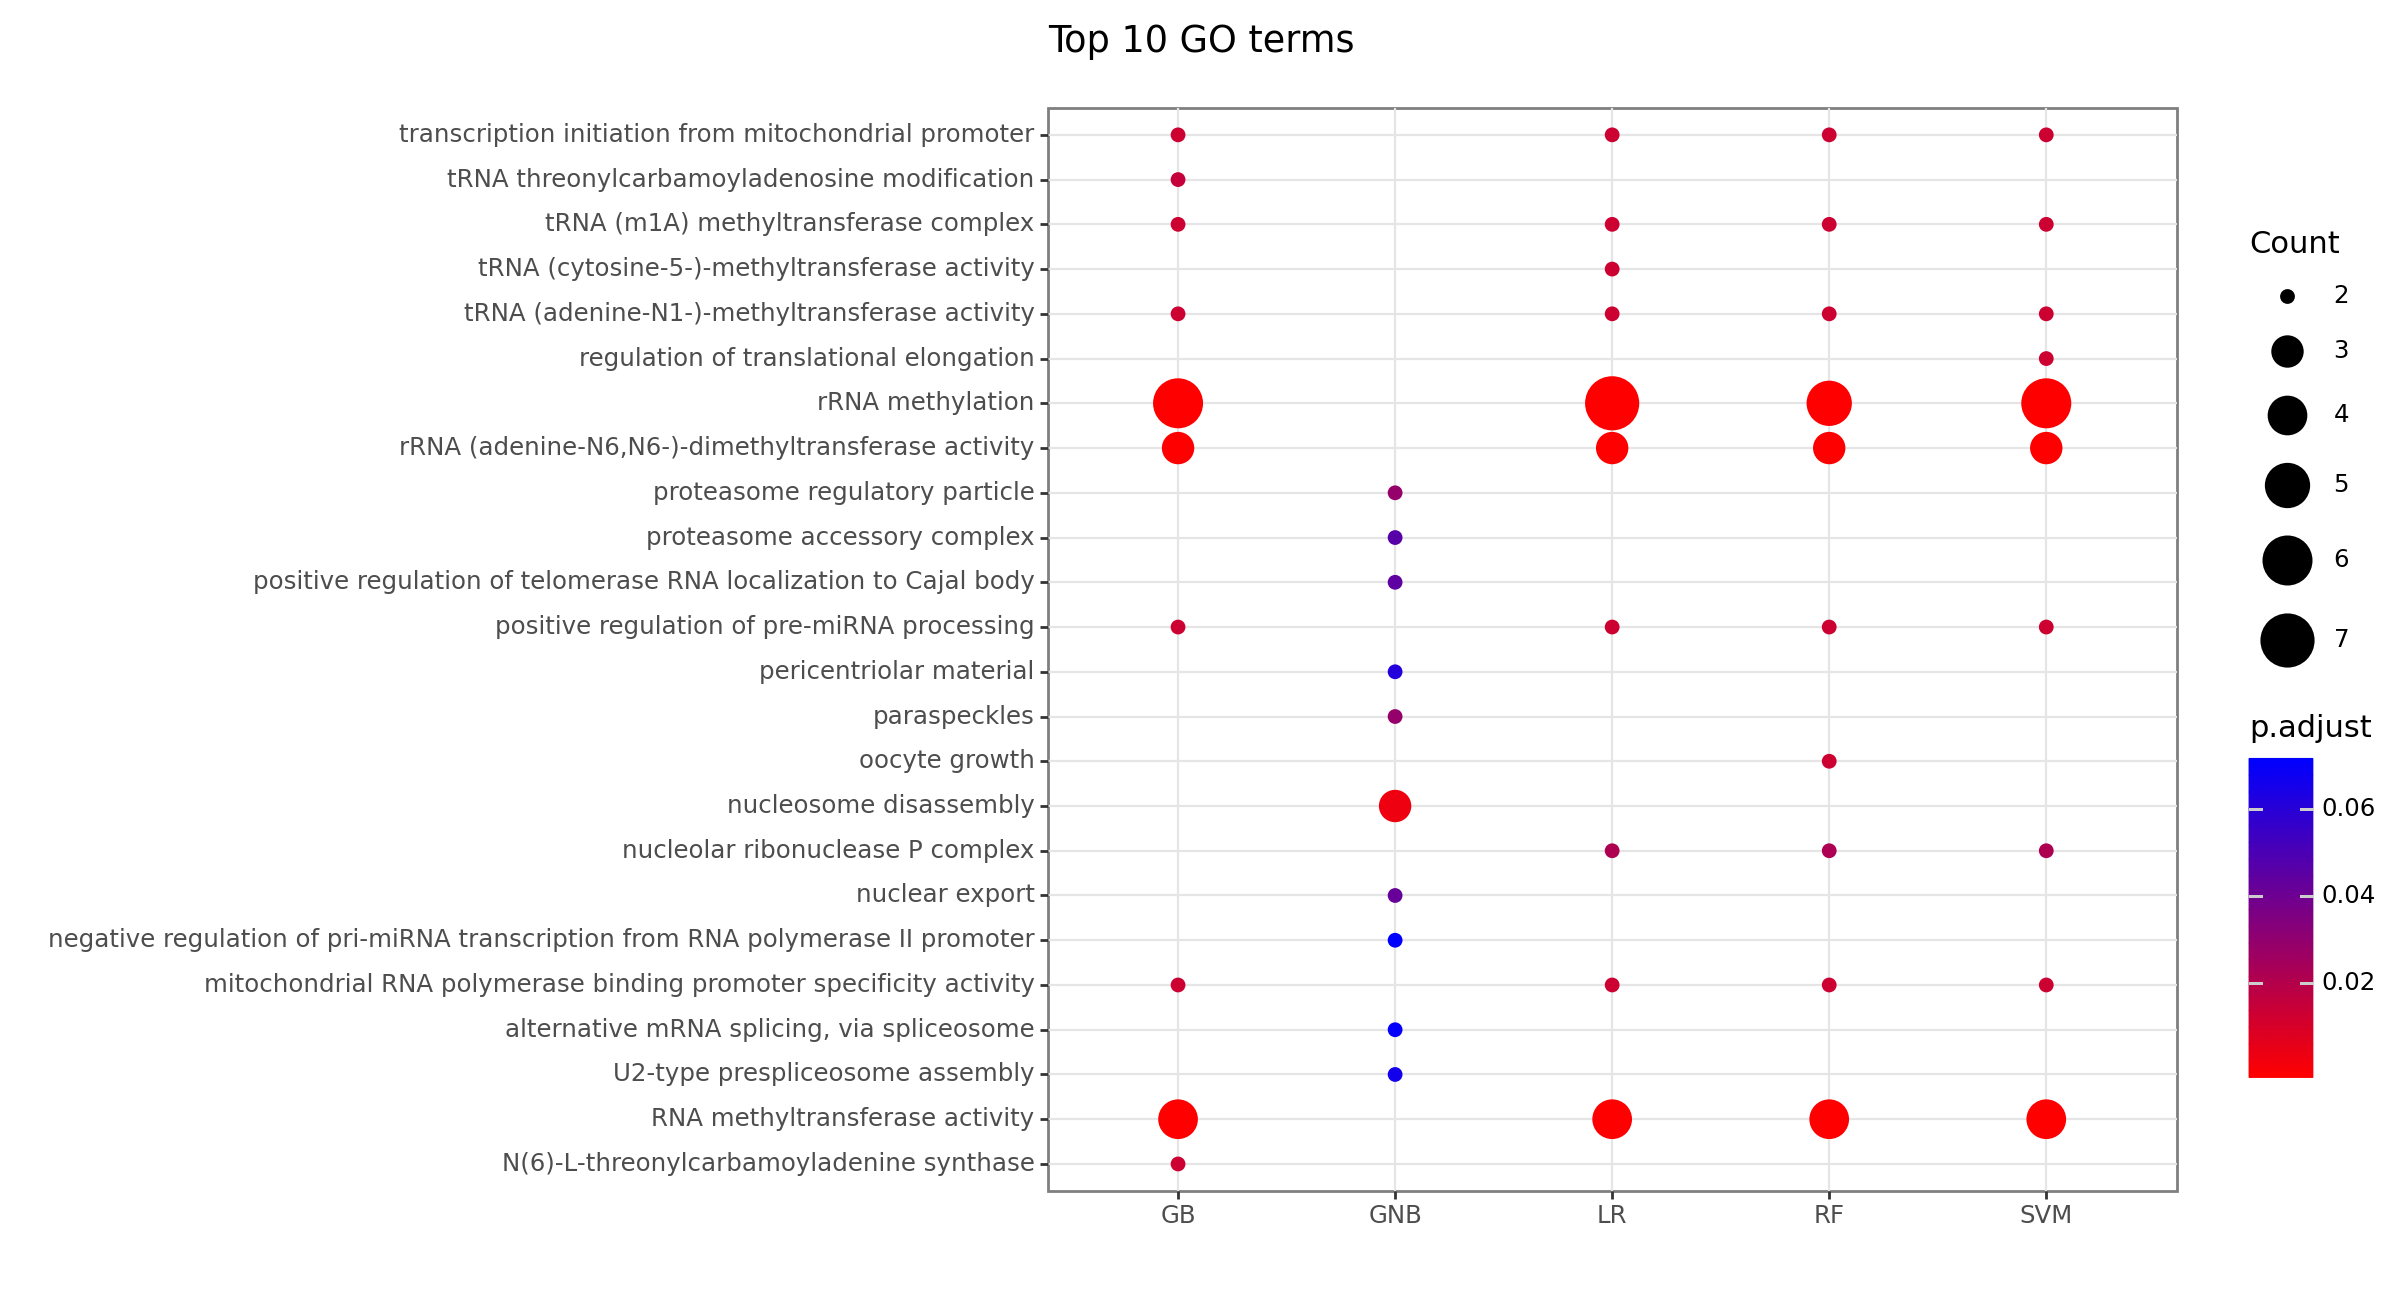

<Figure Size: (1200 x 650)>

In [94]:
from plotnine import *

p = ggplot(all_report, aes(x='Classifier', y='Term', size='Count', color='PAdjust')) + geom_point(alpha=1)


p = p + scale_size(range=[2,10])

p = p + scale_color_gradient(low='red', high='blue')

p = p + labs(title='Top 10 GO terms', x='', y='',color = 'p.adjust')

p = p + theme_bw()

p = p+ theme(figure_size=(12, 6.5),plot_background=element_rect(fill="white"),legend_key=element_blank())

ggsave(p,"go terms plot.svg")
p


In [102]:

from goatools.associations import read_ncbi_gene2go
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.go_enrichment import GOEnrichmentStudy

# 下载并加载 GO 数据库文件
obo_path = download_go_basic_obo()
obodag = GODag(obo_path)
gene2go = read_ncbi_gene2go('gene2go', taxids=[9606])
pop = set(gene2go.keys())
# 定义基因列表


  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-10-09) 46,296 Terms
DEPRECATED read_ncbi_gene2go: USE Gene2GoReader FROM goatools.anno.genetogo_reader
DEPRECATED read_ncbi_gene2go CALLED FROM: C:\Users\tuoge\AppData\Local\Temp\ipykernel_4580\2692182736.py BY <module>
HMS:0:00:19.905613 344,728 annotations, 20,761 genes, 18,831 GOs, 1 taxids READ: gene2go 
18671 IDs in loaded association branch, BP

Load  Ontology Enrichment Analysis ...
  0%      0 of      3 population items found in association


TypeError: run_study() missing 1 required positional argument: 'study'

In [106]:
gene_list = ['METTL2A','METTL2B','FTSJ2']

# 执行 GO 富集分析
goeaobj = GOEnrichmentStudy(
    gene_list,
    gene2go,
    obodag,
    propagate_counts=False,
    methods=['fdr_bh']
)


goea_results = goeaobj.run_study(gene_list)

# 打印富集分析结果
for item in goea_results:
    print(item.GO, item.name, item.p_fdr_bh)


Load  Ontology Enrichment Analysis ...
  0%      0 of      3 population items found in association

Runing  Ontology Analysis: current study set of 3 IDs.
  0%      0 of      3 study items found in association
100%      3 of      3 study items found in population(3)
Calculating 0 uncorrected p-values using fisher_scipy_stats


In [107]:
goea_results


[]